# Introduction
Fraud has become an ever-rising concern, especially in the UK with PWC reporting that in 2022, fraudsters stole £1.2bn __(PWC, 2023)__. With an alarmingly high figure, the need for a machine learning model to accurately identify fraudulent transactions will not only protect customers from becoming victims of fraud, but also reduce the amount financial instituations obligated to pay-out compensation to victims.

## Data Source
For this project, I utilized a publicly available dataset from Kaggle (Lopez-Rojas, 2016), containing over a six-million transaction records with details on:

- Transaction type (e.g., payment, cash out, transfer).
- Source and destination account information: names, balances before and after the transaction.
- Transaction amount.
- Fraud indicators: a binary label indicating whether the transaction was fraudulent and an additional flag showing if it was marked as such.

The wealth of information included in this data set will allow for a deep analysis of transactions, helping identify patterns existent in fraudulent transactions.

## Objective
The aim is to build a model that is able to detect fraudulent transactions based on a value of the properties listed above. Fraud detection is inherently a classification problem with two main classes: non-fraudulent and fraudulent. The distribution of these classes is heavily imbalanced, with fraudulent transactions only making up 0.18% of the first one million transactions listed (can only view one million items on Excel). Said imbalance creates a significant challenge, as the model trained on this data will likely perform poorly when making predictions for the fraudulent class - a detrimental problem if this model was to be deployed in a production environment.

Given the aforementioned challenges, two identified main goals are:
1. To build and optimise a classifier that can successfully differentiate between fraudulent and non-fraudulent transactions to a high standard.
2. Effectively handle the class imbalance by adjusting data distribution between train and test sets and evaluating the model's performance against various metrics.

## Intended Impact
Accurately detecting fraudulent transactions has significant benefits, from preventing losses for financial institutions to protecting individual customers. Moreover, this approach to automated fraud detection can save valuable resources by reducing the need for manual transaction review and allow companies to respond more quickly to potential fraud cases.


## References
***PWC. (2023). UK Banking Fraud Sentiment Index. [online] Available at: https://www.pwc.co.uk/forensic-services/assets/documents/uk-banking-fraud-sentiment-index.pdf [Accessed 18 Oct. 2024].***

***Lopez-Rojas, E. (2016). Synthetic Financial Datasets For Fraud Detection. [online] Kaggle.com. Available at: https://www.kaggle.com/datasets/ealaxi/paysim1 [Accessed 18 Oct. 2024].***

In [35]:
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn import metrics

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier

### Helper Functions

In [36]:
# Plot scatter showing relationship between transaction amount and original balance of source account
def create_scatter(x_train, y_train, x_test, y_test):
    plt.figure(figsize=(20,10))
    colourMap = colors.ListedColormap(['green', 'red'])

    plt.scatter(x_train["amount"], x_train["oldbalanceOrg"], c=y_train, cmap=colourMap, alpha = 0.5, label="Train", marker="o" )
    plt.scatter(x_test["amount"], x_test["oldbalanceOrg"], c=y_test, cmap=colourMap, alpha = 0.5, label="Test", marker="x")

    plt.ylabel("Original Balance of Source Account")
    plt.xlabel("Amount of Transaction")

    plt.yscale('log')
    plt.xscale('log')

    plt.legend() 
    redPatch = mpatches.Patch(color='green', label='Not Fraudulent')
    greenpatch = mpatches.Patch(color='red', label='Fraudulent')
        
    ax = plt.gca()
    leg = ax.get_legend()
    plt.legend(handles=[leg.legend_handles[0],leg.legend_handles[1], redPatch, greenpatch])

    plt.plot()

# Extract outliers where the amount transferred is greater than the original balance of the source account
def extract_outliers_high(dataset, threshold):
    outliers = dataset[dataset['amount'] > threshold * dataset['oldbalanceOrg']]
    return outliers

# Extract outliers where the amount transferred is less than the original balance of the source account
def extract_outliers_low(dataset, threshold):
    outliers = dataset[dataset['amount'] < dataset['oldbalanceOrg'] / threshold]
    return outliers


# 2. Data Exploration and Preprocessing
## Subsection A: Initial Data Exploration


Initial exploration of the dataset, figure 1, revealed that in the initial sample (2000 rows), there was a significant class imbalance, with only 7.7% of the sample being fraudulent. Model training on this sample led to incredible accuracy, with the model achieving accuracy scores of 100% and 99% in the train and test data, respectively.

Upon further analysis, this result was strongly attributed to the fact that there was such a low number of fraudulent cases to train the data on, and so the model likely became overfitted to the non-fraudulent class. Furthermore, because only 7.7% of the sample was fraudulent, the model could predict that the transaction was non-fraudulent and be correct 92.3% of the time.

To further reinforce this assumption, a confusion matrix was constructed and illustrated that there were 493 true negatives (i.e., non-fraudulent transactions), 2 true positives, 2 false negatives, and 3 false positives, suggesting that of the non-fraudulent transactions, the model was good at predicting these, but, relative to the class size, performed poorly when predicting how many transactions were actually fraudulent.

To consolidate the findings above, the model's F1 score on this sample was 0.44, highlighting its limited effectiveness, particularly in identifying the minority class.

In [37]:
# Fraud detection in bank accounts
dataset = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [38]:
initial_data = dataset[:2000]

In [39]:
# input
x = initial_data.drop("isFraud", axis='columns')

# output
y = initial_data["isFraud"]

# Remove obselete columns
x = x.drop(["nameOrig", "nameDest"], axis="columns")

In [40]:
# Split data into training and testing sets 
x_train,x_test,y_train,y_test = train_test_split(x,y)

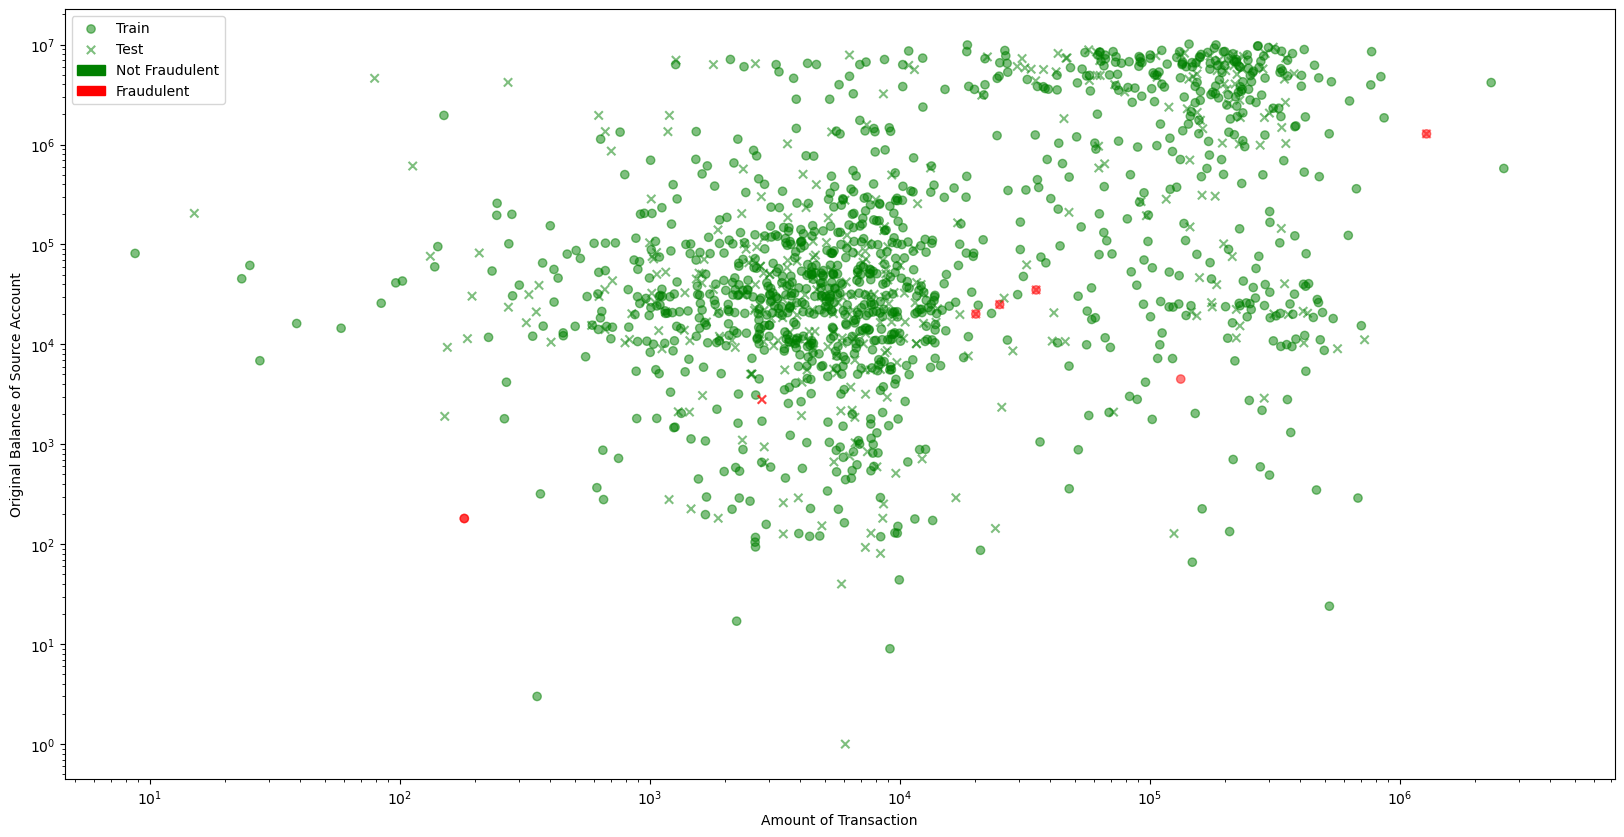

In [41]:
create_scatter(x_train, y_train, x_test, y_test)

***Figure 1: Initial State of Data***



## Subsection B: Balancing the Dataset and Enhancing Features
The goal was to train the model on a more balanced dataset by extracting 1,050 fraudulent and 2,450 non-fraudulent transactions, achieving a 30/70 split between the two categories. This adjustment significantly boosted model performance, with a 0.52 increase in F1 score, 259 additional true positives, and one fewer false negative, indicating the model’s improved ability to detect fraudulent activity.

Figure 2 shows the adjusted training data, highlighting that most fraudulent transactions align with a linear trend where the transaction amount matches the original account balance. While this pattern enhanced the model's accuracy, it raised questions about its ability to detect outliers. Only 1% of fraudulent data points fell outside this trend (not shown in figure 2). To address this, I identified and added all outliers (transactions where the amount is 1.5 times higher or lower than the original balance) into the sample.

The results confirmed that the model struggled with outliers, yielding 7 false negatives. As I felt that data manipulation was now finished, the best course of action to improve the results at this point was to fine-tune the hyperparameters, which I explain further in section 3.

In [42]:
fraudulent_data = dataset[dataset['isFraud'] == 1]
non_fraudulent_data = dataset[dataset['isFraud'] == 0]

# 30% of total data set is fraudulent
fraudulent_data = fraudulent_data[:1050]

#70% of total data set is non-fraudulent
non_fraudulent_data = non_fraudulent_data[:2450]

# 3500 total data points
proportionate_dataset = pd.concat([fraudulent_data, non_fraudulent_data],ignore_index=True)

# Shuffle data
proportionate_dataset = proportionate_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [43]:
fraudulent_data = dataset[dataset['isFraud'] == 1]

In [44]:
# Extract outliers from all fraudulent data
fraudulent_outliers_hi = extract_outliers_high(fraudulent_data, 1.5)
fraudulent_outliers_lo = extract_outliers_low(fraudulent_data, 1.5)

In [45]:
# Split high and low outliers into training and testing sets
train_outliers_hi = fraudulent_outliers_hi[len(fraudulent_outliers_hi)//2:]
test_outliers_hi = fraudulent_outliers_hi[:len(fraudulent_outliers_hi)//2]

train_outliers_lo = fraudulent_outliers_lo[len(fraudulent_outliers_lo)//2:]
test_outliers_lo = fraudulent_outliers_lo[:len(fraudulent_outliers_lo)//2]

In [46]:
rows_to_drop = proportionate_dataset[proportionate_dataset['isFraud'] == 1].index

rows_to_drop = rows_to_drop[:len(fraudulent_outliers_hi) + len(fraudulent_outliers_lo)]

# Replace the last rows_to_drop fraudulent data rows in the dataset with the outliers
proportionate_dataset2 = proportionate_dataset.drop(rows_to_drop)

# Evenly split dataset into training and testing sets
train_proportionate_dataset = proportionate_dataset2[len(proportionate_dataset2)//2:]
test_proportionate_dataset = proportionate_dataset2[:len(proportionate_dataset2)//2]


In [47]:
# Create even split of train and test data with equal numbers of high and low outliers
train_outliers = pd.concat([train_outliers_hi, train_outliers_lo],ignore_index=True)
test_outliers = pd.concat([test_outliers_hi, test_outliers_lo],ignore_index=True)


In [48]:
# Evenly split outliers into training and testing sets
train_data = pd.concat([train_proportionate_dataset, train_outliers],ignore_index=True)
test_data = pd.concat([test_proportionate_dataset, test_outliers],ignore_index=True)

In [49]:
# Split the data intended for training into input and output
#input
x_for_train = train_data.drop("isFraud", axis='columns')

#output
y_for_train = train_data["isFraud"]

# Remove obselete columns
x_for_train = x_for_train.drop(["nameOrig", "nameDest"], axis="columns")

x_train1,x_test1,y_train1,y_test1 = train_test_split(x_for_train,y_for_train, stratify=y_for_train,random_state=42)

In [50]:
# Split the data intended for testing into input and output
#input
x_for_test = test_data.drop("isFraud", axis='columns')

#output
y_for_test = test_data["isFraud"]

# Remove obselete columns
x_for_test = x_for_test.drop(["nameOrig", "nameDest"], axis="columns")

x_train2,x_test2,y_train2,y_test2 = train_test_split(x_for_test,y_for_test, stratify=y_for_test,random_state=42)

In [51]:
# Join the two sets of splits 
x_train = pd.concat([x_train1, x_train2],ignore_index=True)
x_test = pd.concat([x_test1, x_test2],ignore_index=True)
y_train = pd.concat([y_train1, y_train2],ignore_index=True)
y_test = pd.concat([y_test1, y_test2],ignore_index=True)

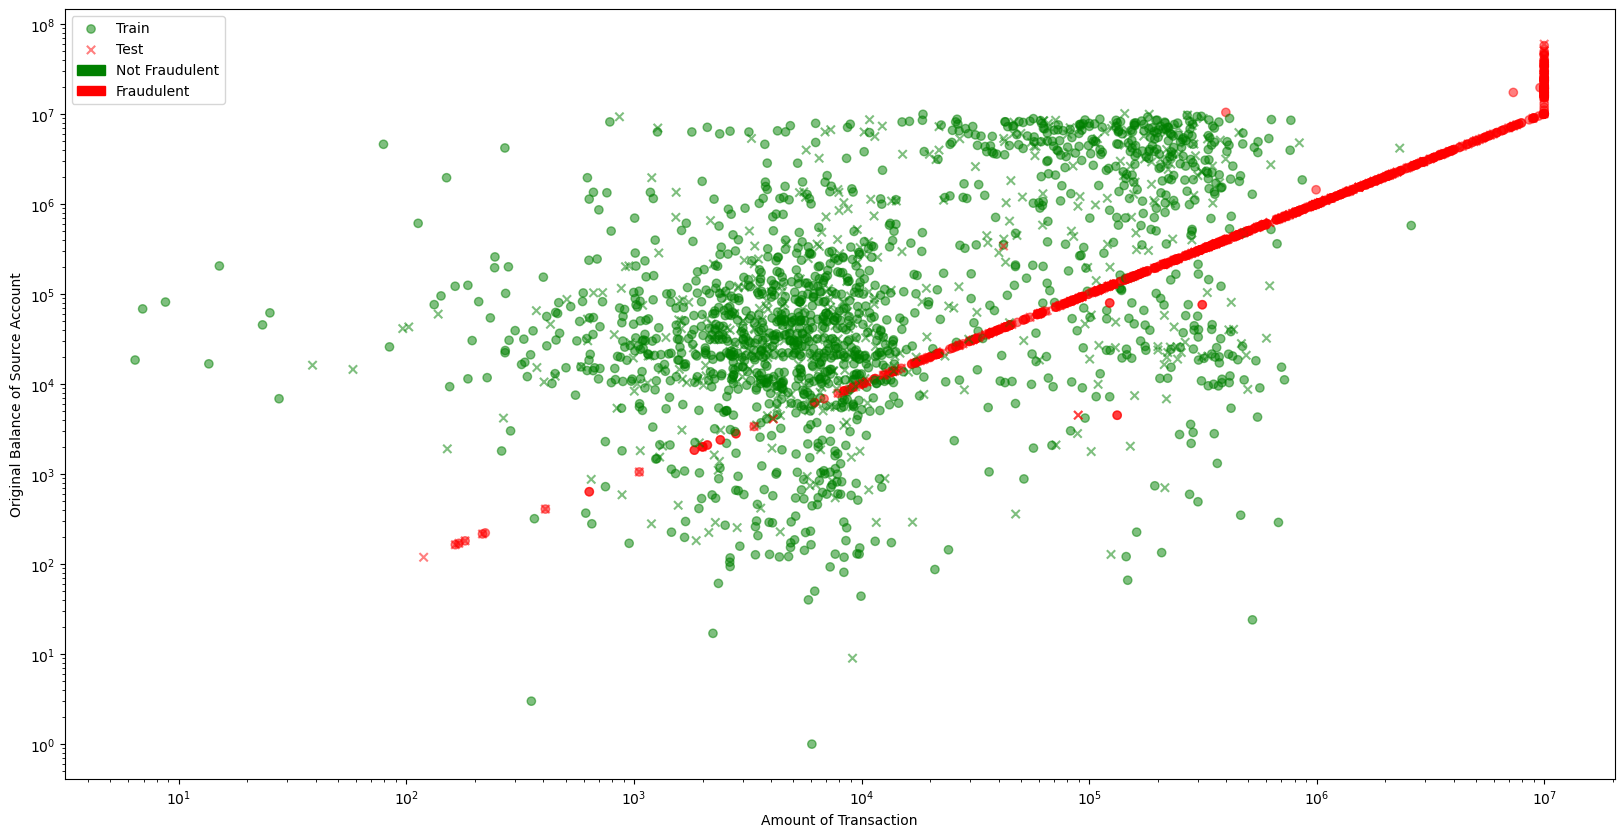

In [52]:
# Generate scatter plot showing relationship between transaction amount and original balance of source account with outliers included
create_scatter(x_train, y_train, x_test, y_test)

***Figure 2: Injection of Fraudulent Data & Outliers***


# 3. Model Selection and Baseline Model
## Subsection A: Baseline Model Setup
The baseline model uses a decision tree classifier due to its strong pattern-recognition abilities, which align well with the dataset's structure as presented in Figure 2. Given the consistency in fraudulent transaction patterns, a decision tree classifier was chosen over alternatives like random forest and K-Nearest Neighbors for its interpretability and suitability for this task. The model was fitted with only the random_state hyperparameter set purely for reproducibility, but additional hyperparameters were added in later iterations of this model, which will be covered in subsection B.

## Subsection B: Model Iteration Process
With no hyperparameters set, the model was performing poorly given the context in which it is being used, producing 7 false negatives which, in practice, will be detrimental. Therefore, the fine-tuning of hyperparameters at this point was specifically aimed at minimising the number of false negatives.

The grid search tool was employed at this stage to find the best selection of hyperparameters given a cross-validation of 5. To avoid overfitting, I selected the most impactful hyperparameters for this scenario: max_depth to prevent the model from overfitting and generalise data better; min_samples_split to prevent nodes with few samples from splitting to avoid creating overfit branches; and min_samples_leaf to ensure each leaf node has enough samples in them to improve the model's ability to generalise. The grid search identified that the best combination of parameters would be:

- max_depth : 20 
- min_samples_leaf: 1
- min_samples_split: 10

This combination increased the F1 score to 0.99 (from 0.98) and decreased the number of false negatives significantly to 2—down by 5. The number of false positives, however, did increase to 2 (from 1), but in fraud detection, it is marginally more favourable to incorrectly flag a non-fraudulent transaction than to miss a fraudulent one.

Nothing further could be done to the hyperparameters, and with such great results, the next step was to compare the results this model produced with the same model fitted on different classifiers. Firstly, I used a K-Nearest Neighbours classifier due to its straightforward approach at classifying data points based on the majority class of the nearest k data points to it. After fitting the model with optimised hyperparameters, I observed that while the test accuracy remained at 99.5%, the number of false predictions increased significantly; more specifically, false negatives rose to 15 and false positives to 25, resulting in an F1 score of 0.93, which was notably lower than that of the decision tree. As a result, I decided to exclude KNN as a viable option for predicting fraudulent transactions in this model.

I then used a random forest classifier due to its similarities with the decision tree classifier, but also its ability to create multiple trees and average predictions makes it more robust to noise and allows for more complex fitting. This model yielded even better results, producing an F1 score of 1.00, and, although it did not further decrease the number of false negatives, it reduced the number of false positives to 0 (from 2). Subsequently, this led me to use this as my final model.

In [ ]:
label_encoder = LabelEncoder()

# transform needed to convert string vals in CSV column to numbers as model cannot train on strings
x_train['type'] = label_encoder.fit_transform(x_train['type'])

# transform used again but NOT fit_transform because you want to test on the same transformation done on train set
x_test['type'] = label_encoder.transform(x_test['type'])

In [ ]:
# Parameters for Random Forest Classifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Grid search for Random Forest Classifier
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid=param_grid_rf, cv=5, scoring='accuracy')

In [ ]:
# Fit the model
grid_search_rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [ ]:
# Display best parameters and cross-validation score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Cross-Validation Score:", grid_search_rf.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.9961868411486732


In [ ]:
# Get best combination of parameters - this also already fits the model
rf_model = grid_search_rf.best_estimator_

In [ ]:
y_train_prediction_rf = rf_model.predict(x_train)
y_test_prediction_rf = rf_model.predict(x_test)


# 4. Final Model Evaluation
## Subsection A: Performance Metrics


In [ ]:
# Generate accuracy scores for train and test data
y_test_accuracy_score_rf = metrics.accuracy_score(y_test, y_test_prediction_rf)
y_train_accuracy_score_rf = metrics.accuracy_score(y_train, y_train_prediction_rf)

In [ ]:
# Print accuracy scores for train and test data
print("Train data accuracy: ", y_train_accuracy_score_rf)
print("Test data accuracy: ", y_test_accuracy_score_rf)

Train data accuracy:  1.0
Test data accuracy:  0.997716894977169


Number of True Negatives: 613.000
Number of True Positives: 261.000
Number of False Negatives: 2.000
Number of False Positives: 0.000


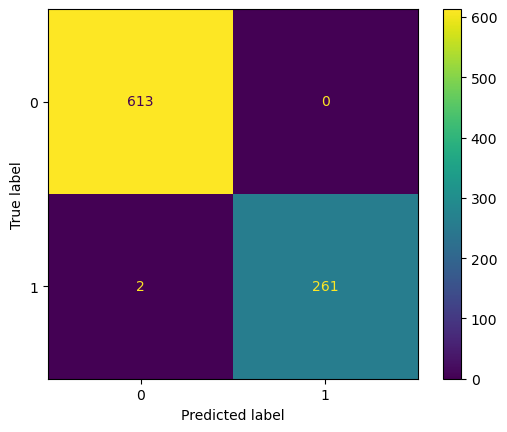

In [ ]:
# plot a confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,y_test_prediction_rf, labels=rf_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=rf_model.classes_)
disp.plot()

# Print confusion matrix values
print("Number of True Negatives: {:.3f}".format(confusion_matrix[0,0]))
print("Number of True Positives: {:.3f}".format(confusion_matrix[1,1]))
print("Number of False Negatives: {:.3f}".format(confusion_matrix[1,0]))
print("Number of False Positives: {:.3f}".format(confusion_matrix[0,1]))

***Figure 3 - Confusion Matrix***

In [ ]:
# print f1 score, precision and recall
f1 = metrics.f1_score(y_test, y_test_prediction_rf)
precision = metrics.precision_score(y_test, y_test_prediction_rf)
recall = metrics.recall_score(y_test, y_test_prediction_rf)

print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

F1 Score: 1.00
Precision: 1.00
Recall: 0.99


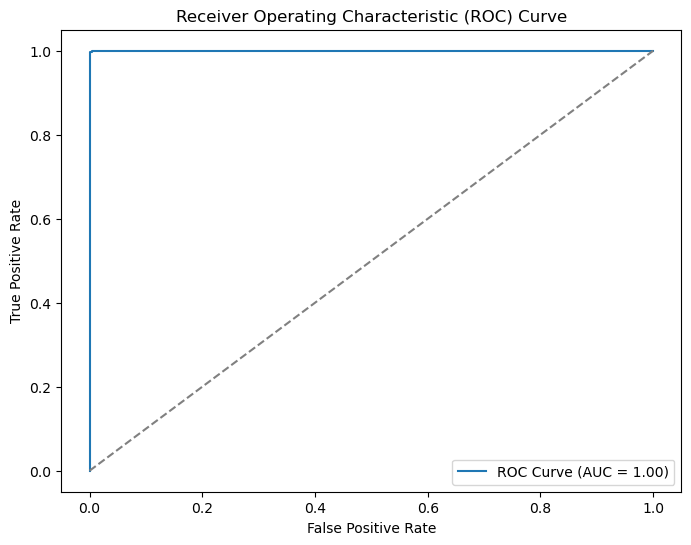

In [ ]:
# Get the probability of the positive class (i.e. Fraudulent transactions)
y_probs = rf_model.predict_proba(x_test)[:, 1]

# Calculate the ROC curve
# fpr = false positive rate, tpr = true positive rate
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

# Calculate the AUC score
auc_score = metrics.roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")

# Plot the random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")

plt.legend(loc="lower right")
plt.show()

***Figure 4: ROC Curve for Random Forest Classifier***

## Subsection B: Interpretation of Results
Training the model with a random forest classifier brought outstanding results; however, a few limitations were observed in taking this approach as opposed to other approaches, e.g. K-Nearest Neighbours or a decision tree classifier:

### Interpretability
Unlike a decision tree classifier, which produces a single tree, random forest classifiers produce multiple trees—200 in the case of this model—and so, while this technique improves accuracy, it conversely makes interpreting individual decision paths more challenging.

### Speed 
Due to the amount of compute a random forest algorithm requires, fitting a model on this classifier takes significantly more time than the other classification approaches that were trialed in training this model. With a dataset of 3,500 items on an eight-core PC running locally, it took, on average, 57.4 seconds to fit the model onto the random forest classifier, raising concerns over the cost of running the model in a production environment where it will likely share resources with other CPU-intensive processes and may be fed much larger quantities of data.


# 5. Conclusions and Next Steps
Overall, the model performs to a great standard with a final F1 score of 100% and an accuracy score of 99.7%, producing no false positives. However, as documented in prior sections, the model did struggle to sometimes classify fraudulent transactions, particularly ones that existed outside the general pattern fraudulent transactions seemed to follow, leading to 2 false negatives being produced when the model was tested against an unseen set of data. Context plays a huge role in determining the success of this model, and with it being developed to predict fraudulent transactions, the perfect target would have been 0 false negatives. However, due to the successful results presented in various other metrics, the fact this model produced 2 false negatives does not suggest that it was a failure, but rather there is scope for further improvement in the future.

## Future Work
### Larger dataset 
The total size of the dataset was just over 6 million, and of that data, the word processing applications I had access to could only present 1 million of them at a time. By only working with approximately 17% of the total dataset, this affected the variety and volume of data I could explore, especially in terms of adjusting the proportion of fraudulent transactions. Moreover, only 117 transactions were labelled as fraudulent outliers—a very small fraction of the data used to train the model. This posed a challenge, not only for addressing class imbalance between fraudulent and non-fraudulent transactions but also for managing the imbalance within the fraudulent class itself (between outliers and non-outliers).

Additionally, training the model on a personal eight-core PC, which was running multiple applications simultaneously, restricted the dataset size I could realistically process. Even with the model being fitted with only 2,750 rows of data, it still took approximately 60 seconds to fit this model using a random forest classifier. If the dataset scaled to 1 million rows (20% of the dataset), processing time could quite possibly increase to about 100 times longer, making it impractical at this current stage to work with larger datasets.

### Neural Network
Neural networks are particularly well-suited for complex pattern recognition tasks due to their ability to learn intricate relationships within the datasets through multiple layers of interconnected nodes. In the future, I plan to implement a neural network to successfully predict and identify fraudulent transactions, with the aim of reducing the number of false negatives the model generates from 2 to 0. Moreover, neural networks also have the ability to adaptively improve as they are presented with more data, not only improving their robustness and generalisation capabilities but also improving their ability to identify new patterns (i.e. new methods of committing fraud) and helping eliminate them expeditiously.